In [42]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.metrics import confusion_matrix
from scipy.optimize import linear_sum_assignment
from scipy.io import loadmat
from tqdm import tqdm

In [26]:
def initialize_membership_matrix(n, c):
    """
    初始化隸屬度矩陣
    n: 數據點數量
    c: 群聚數量
    """
    U = np.random.rand(n, c)
    U /= np.sum(U, axis=1, keepdims=True)
    return U

In [27]:
def update_centroids(data, U, m):
    """
    更新群聚中心點
    data: 數據點 (n_samples, n_features)
    U: 隸屬度矩陣 (n_samples, c)
    m: 模糊權重指數
    """
    um = U ** m
    return (data.T @ um / np.sum(um, axis=0)).T

In [28]:
def update_membership_matrix(data, centroids, m):
    """
    更新隸屬度矩陣
    data: 數據點 (n_samples, n_features)
    centroids: 群聚中心點 (c, n_features)
    m: 模糊權重指數
    """
    n = data.shape[0]
    c = centroids.shape[0]
    p = 2. / (m - 1)
    U = np.zeros((n, c))
    for i in range(n):
        x = data[i]
        dists = np.linalg.norm(x - centroids, axis=1)
        U[i] = 1. / np.sum((dists / dists[:, np.newaxis]) ** p, axis=0)
    return U

In [29]:
def fuzzy_c_means(data, c, m, error=0.005, maxiter=100):
    """
    Fuzzy C-Means 算法實現
    data: 數據點 (n_samples, n_features)
    c: 群聚數量
    m: 模糊權重指數
    error: 收斂誤差閾值
    maxiter: 最大迭代次數
    """
    n = data.shape[0]
    U = initialize_membership_matrix(n, c)
    iteration = 0
    with tqdm(total=maxiter, desc="FCMM Iteration") as pbar:
        while iteration < maxiter:
            U_old = U.copy()
            centroids = update_centroids(data, U, m)
            U = update_membership_matrix(data, centroids, m)
            if np.linalg.norm(U - U_old) < error:
                break
            iteration += 1
            pbar.update(1)
    return U, centroids


In [33]:
# Load salinas Hyperspectral Dataset

mat_data = loadmat('./dataset/pavia_university/PaviaU.mat')
gt_data = loadmat('./dataset/pavia_university/PaviaU_gt.mat')

# 提取高光譜影像數據和地面真實值
img = mat_data['paviaU']
gt = gt_data['paviaU_gt']

classes = np.unique(gt)
print("Class labels:", classes)
#將三維數據降至二維
data = img.reshape(-1, img.shape[-1])

U, centroids = fuzzy_c_means(data, c=10, m=1.5)
# print("Centroids:", centroids)

Class labels: [0 1 2 3 4 5 6 7 8 9]


FCMM Iteration:  65%|██████▌   | 65/100 [05:40<03:03,  5.24s/it]


(207400,)
(610, 340)


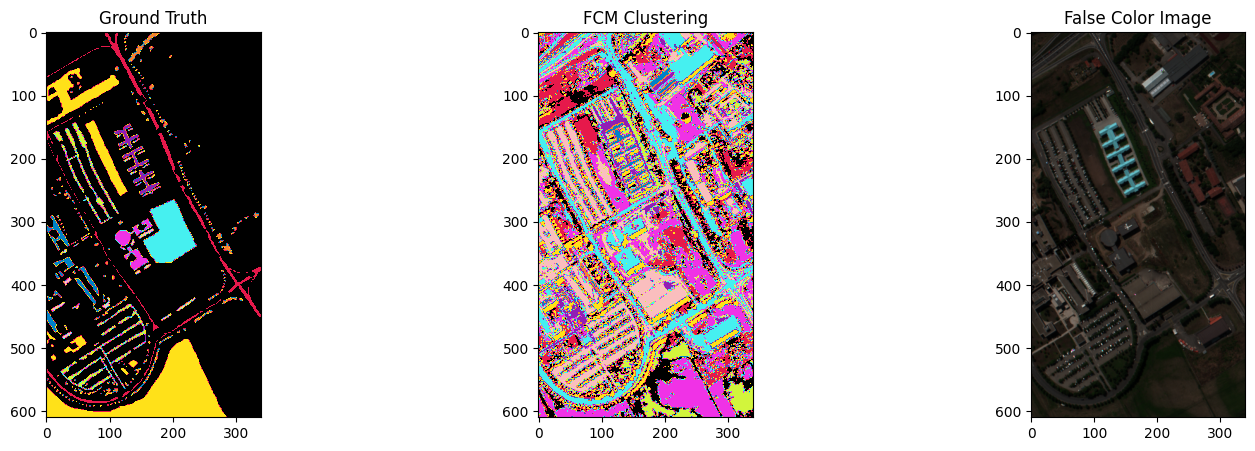

In [38]:
labels = np.argmax(U, axis=1)
print(labels.shape)
clustered_img = labels.reshape(img.shape[:2])
print(clustered_img.shape)

# 定義9種顏色
colors = [
    "#000000", "#e6194b", "#ffe119", "#0082c8", "#f58231", "#911eb4", "#46f0f0", "#f032e6",
    "#d2f53c", "#fabebe"
]
cmap = ListedColormap(colors)


plt.figure(figsize=(18, 5))

# Ground Truth
plt.subplot(1, 3, 1)
plt.title("Ground Truth")
plt.imshow(gt, cmap=cmap)

# FCM Clustering Result
plt.subplot(1, 3, 2)
plt.title("FCM Clustering")
plt.imshow(clustered_img, cmap=cmap)

# False Color Image (使用波段 50, 27, 17)
false_color_img = img[:, :, [50, 27, 17]]

# 縮放假彩色圖像的值到0-255範圍
false_color_img = (false_color_img - false_color_img.min()) / (false_color_img.max() - false_color_img.min()) * 255
false_color_img = false_color_img.astype(np.uint8)

plt.subplot(1, 3, 3)
plt.title("False Color Image")
plt.imshow(false_color_img)

plt.show()

Accuracy: 23.68%
Overall Accuracy (OA): 23.68%
Average Accuracy (AA): 47.83%


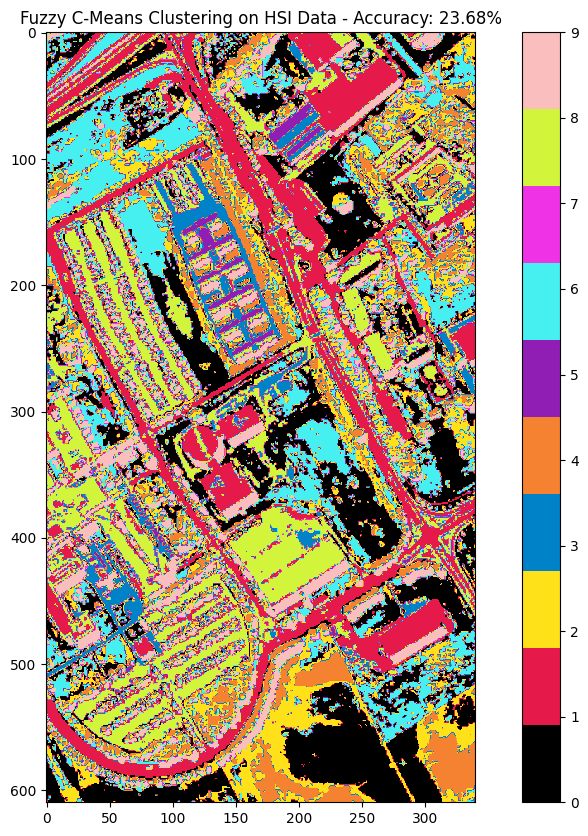

In [55]:
# 並且已經有 gt 加載和重塑為一維向量
gt_flat = gt.flatten()

# 計算混淆矩陣
cm = confusion_matrix(gt_flat, labels)

# 使用匈牙利算法找到最佳標籤對應
row_ind, col_ind = linear_sum_assignment(-cm)  # 對成本矩陣取負值以求最大化

# 建立標籤映射，根據找到的對應關系重映射 FCM 的結果
label_mapping = {col: row for col, row in zip(col_ind, row_ind)}
remapped_labels = np.array([label_mapping[label] for label in labels])

# 計算重映射後的準確率
accuracy = np.sum(remapped_labels == gt_flat) / gt_flat.size
print(f"Accuracy: {accuracy * 100:.2f}%")

cm_news = confusion_matrix(gt_flat, remapped_labels)

# 計算整體精確度 (Overall Accuracy, OA)
OA = np.trace(cm_news) / np.sum(cm_news)
print(f"Overall Accuracy (OA): {OA * 100:.2f}%")

# 計算平均精確度 (Average Accuracy, AA)
class_accuracies = np.diag(cm_news) / np.sum(cm_news, axis=1)
AA = np.mean(class_accuracies)
print(f"Average Accuracy (AA): {AA * 100:.2f}%")

# 可視化重映射後的分群結果
remapped_clustered_img = remapped_labels.reshape(img.shape[:2])

plt.figure(figsize=(12, 10))
plt.imshow(remapped_clustered_img, cmap=cmap)
plt.colorbar()
plt.title(f'Fuzzy C-Means Clustering on HSI Data - Accuracy: {accuracy * 100:.2f}%')
plt.show()

(610, 340)
Overall Accuracy (OA): 0.23677434908389586
Average Accuracy (AA): 0.5110892946279909


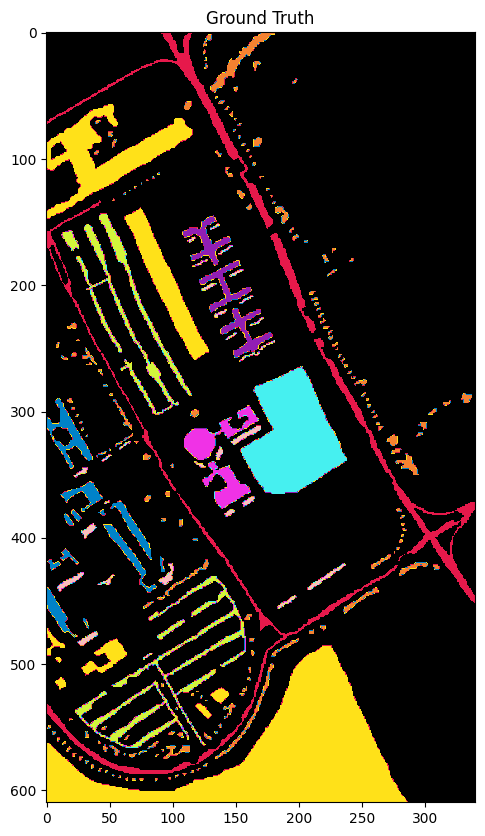

In [53]:
# 計算整體準確度 (OA)
def overall_accuracy(predicted, gt):
    correct = np.sum(predicted == gt)
    total = np.prod(gt.shape)
    return correct / total

# 計算平均準確度 (AA)
def average_accuracy(predicted, gt):
    classes = np.unique(gt)
    accuracies = []
    for cls in classes:
        if cls != 0:  # 假設0是背景或未標記的類別
            cls_mask = (gt == cls)
            correct = np.sum((predicted == cls) & cls_mask)
            total = np.sum(cls_mask)
            accuracies.append(correct / total)
    return np.mean(accuracies)

print(gt.shape)

oa = overall_accuracy(remapped_labels, gt_flat)
print("Overall Accuracy (OA):", oa)

# AA 計算
aa = average_accuracy(remapped_labels, gt_flat)
print("Average Accuracy (AA):", aa)

# Ground Truth
plt.figure(figsize=(12, 10))
plt.title("Ground Truth")
plt.imshow(gt, cmap=cmap)